Notes:
* in data file (.csv), the stratigraphic in `formation` column should be listed from old to young.
* in the dataset, the dtype `int64` need to be converted to `float`.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import plot
import models
from feature_ecoding.clip_surface import Fault_feature
import torch
import pandas as pd
import os
import importlib

In [2]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    num_GPU = torch.cuda.device_count()
    print(f"GPU amount: {num_GPU}")
else:
    num_GPU = 0

print(f"device: {device}")
root_path = os.path.abspath('.')

GPU amount: 1
device: cuda


1. load observational data

In [3]:
# load data
surface_points = pd.read_csv(os.path.join(root_path, 'data', 'case1', 'original_data', 'tut_ch1-5_points.csv'))
orientation_points = pd.read_csv(os.path.join(root_path, 'data', 'case1', 'original_data', 'tut_ch1-5_orientations.csv'))
# convert int64 to float
surface_points = surface_points.apply(lambda col: pd.to_numeric(col, errors='ignore').astype(float) if col.dtype == 'int64' else col)
orientation_points = orientation_points.apply(lambda col: pd.to_numeric(col, errors='ignore').astype(float) if col.dtype == 'int64' else col)
# define the domain boundary
extent = [0, 1000, 0, 1000, -1000, -400]

In [4]:
orientation_points

,X,Y,Z,dx,dy,dz,formation,group,type
0,550.0,500.0,-600.0,-8.949344e-01,9.580000e-18,0.446198,fault2,fault2,fault
1,350.0,500.0,-700.0,8.949344e-01,1.000000e-12,0.446198,fault1,fault1,fault
2,400.0,500.0,-625.0,1.000000e-12,1.000000e-12,1.000000,rock4,B,stratigraphic
3,150.0,500.0,-550.0,1.000000e-12,1.000000e-12,1.000000,rock4,A,stratigraphic
4,850.0,500.0,-525.0,1.000000e-12,1.000000e-12,1.000000,rock4,C,stratigraphic
5,400.0,500.0,-675.0,1.000000e-12,1.000000e-12,1.000000,rock3,B,stratigraphic
6,150.0,500.0,-600.0,1.000000e-12,1.000000e-12,1.000000,rock3,A,stratigraphic
7,850.0,500.0,-575.0,1.000000e-12,1.000000e-12,1.000000,rock3,C,stratigraphic
8,850.0,500.0,-625.0,1.000000e-12,1.000000e-12,1.000000,rock2,C,stratigraphic
9,150.0,500.0,-650.0,1.000000e-12,1.000000e-12,1.000000,rock2,A,stratigraphic


In [5]:
surface_points

,X,Y,Z,formation,group,type
0,500.0,500.0,-700.0,fault2,fault2,fault
1,500.0,200.0,-700.0,fault2,fault2,fault
2,500.0,800.0,-700.0,fault2,fault2,fault
3,550.0,200.0,-600.0,fault2,fault2,fault
4,550.0,500.0,-600.0,fault2,fault2,fault
...,...,...,...,...,...,...
67,900.0,200.0,-525.0,rock4,C,stratigraphic
68,900.0,500.0,-525.0,rock4,C,stratigraphic
69,900.0,800.0,-525.0,rock4,C,stratigraphic
70,400.0,500.0,-625.0,rock4,B,stratigraphic


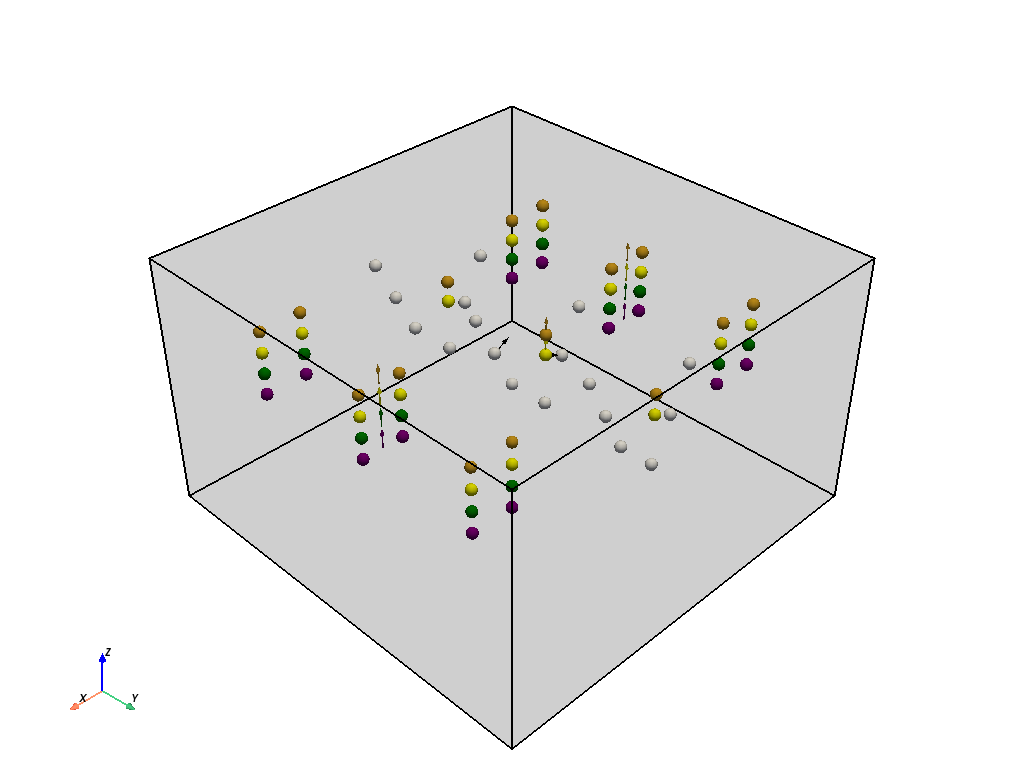

In [6]:
# plot the data
plot.observation(surface_points, orientation_points, extent, notebook=True)

2. modeling fault surfaces
* modeling all the faults
* in this case, fault1 was cut by fault2, the fault1 need to be manually edited

In [7]:
mesh = models.fault_ConcatMLP(surface_points,           # original data read from csv file
                            orientation_points,         # original data read from csv file
                            extent,                     # domain boundary
                            resolution=[60, 30, 30],    # resolution of the fault mesh, lower resolution can reduce the computation time in feature encoding step
                            in_dim=3,                   # input dimension of neural network
                            hidden_dim=256,             # hidden layer's dimension of neural network
                            out_dim=1,                  # output dimension of neural network, the only output is a scalar value
                            n_hidden_layers=2,          # number of hidden layers
                            activation='Softplus',      # activation function, default is 'Softplus'
                            beta_list=[10, 10],           # `beta` values for Softplus activation function, the length related to the number of faults
                            concat = True,              # whether to concat the input features to hidden layers
                            epochs=500,                 # number of forward and backward propagation process 
                            lr=0.001,                   # learning rate
                            above_below=False)          # whether to use `above_below` loss function, default is False

Finish modeling fault2 | Loss_i: 0.01689250022172928, Loss_o: 0.01408076286315918
Finish modeling fault1 | Loss_i: 0.017417388036847115, Loss_o: 0.015287399291992188
------Finish-------


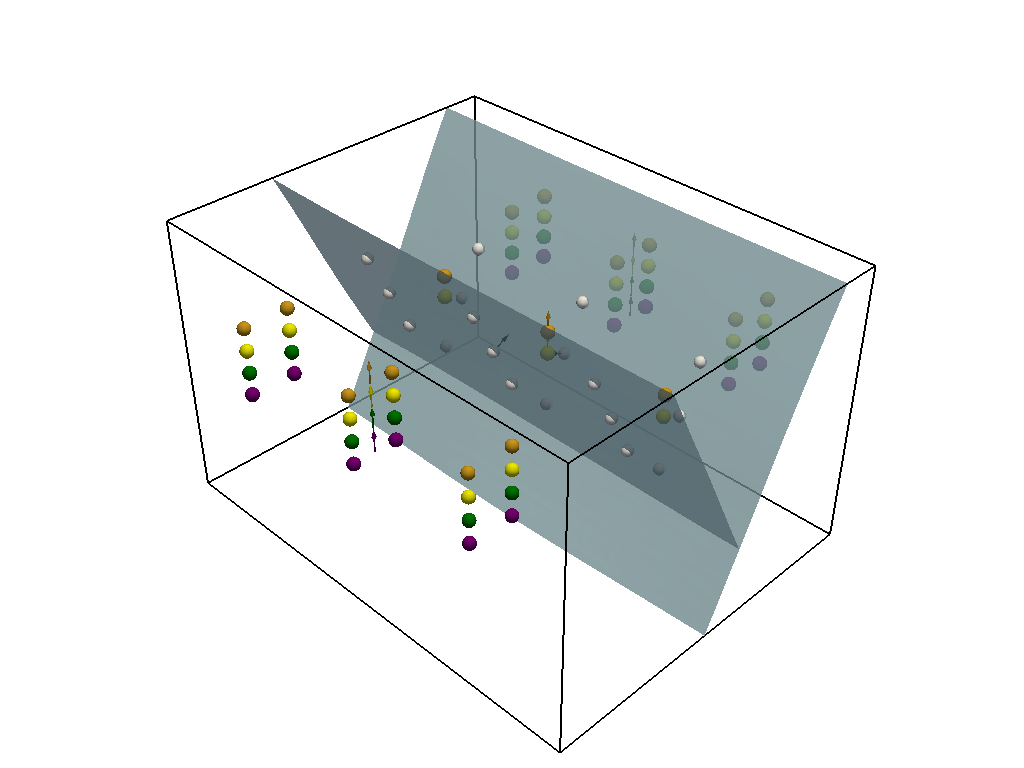

In [8]:
# manually clip the fault surfaces
fault_1 = mesh[0]
fault_2 = mesh[1]
finit_fault_1 = fault_1.clip_surface(fault_2, invert=True)

plot.fault_mesh([finit_fault_1, fault_2], surface_points, orientation_points, extent, notebook=True)

3. fault feature encoding
* because fault1 was cut by fault2, the scalar field in the left side of fault2 should be continuous 
* use mask operation 

In [9]:
domain_mesh_features, label_interf_all, orie_points_all = Fault_feature.encoding(extents=extent,    # domain boundary
                                                            resolution=[100, 100, 100],             # resolution of the domain mesh
                                                            mesh_list=mesh,                         # fault mesh list
                                                            surface_points=surface_points,          # original data read from csv file
                                                            orientation_points=orientation_points,  # original data read from csv file
                                                            movement=['up','down'],                 # relative movement in fault right side
                                                            fault_direct=['left','right'],          # fault surface direction, insures correct feature encoding
                                                            decimate=0.999)   # remove 99.9% of the points in the fault mesh to accelate fault feature encoding

In [10]:
# mask operation to change the feature encoding of fault1
mask_domain_mesh_features = (domain_mesh_features[:,-2] == 1) & (domain_mesh_features[:,-1] == 1)
mask_label_interf_all = (label_interf_all[:,-2] == 1) & (label_interf_all[:,-1] == 1)
mask_orie_points_all = (orie_points_all[:,-2] == 1) & (orie_points_all[:,-1] == 1)

domain_mesh_features[:,-2][mask_domain_mesh_features] = 0     # [:,-2] is the feature encoding of fault1
label_interf_all[:,-2][mask_label_interf_all] = 0    
orie_points_all[:,-2][mask_orie_points_all] = 0

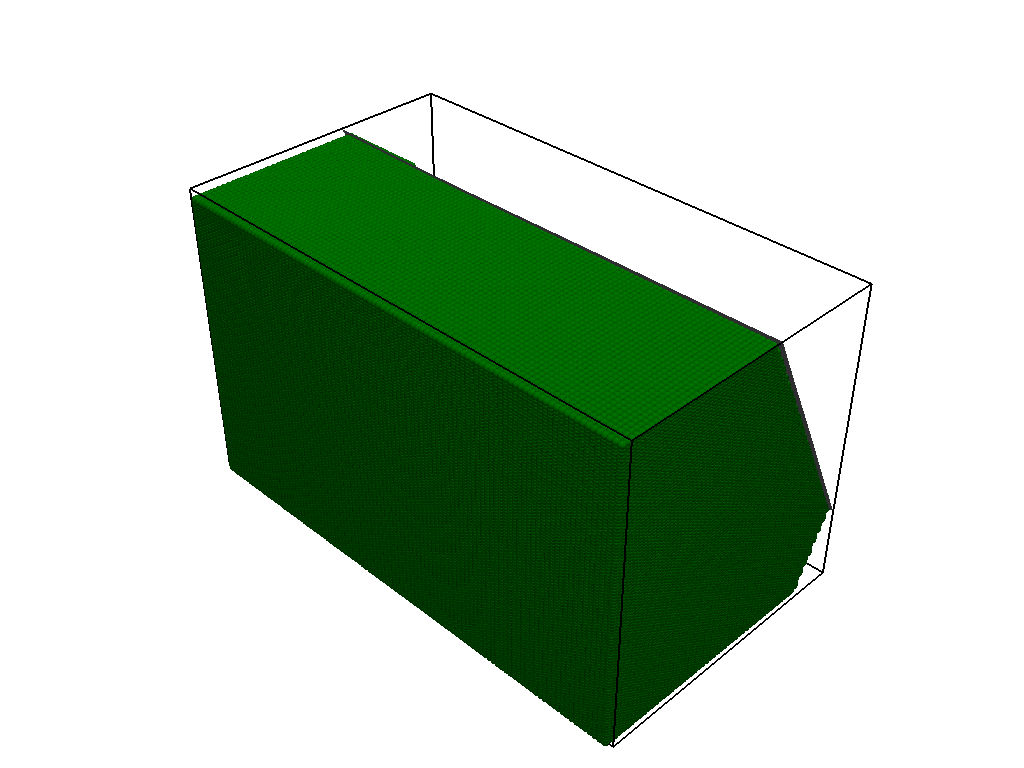

In [11]:
plot.feature_encoding(mesh_list=[finit_fault_1, fault_2],        # fault mesh list after editing
                      number=0,                                  # 0 is the first mesh, 1 is the second mesh
                      extent=extent,                             # domain boundary
                      type='mesh_point',                         # 'mesh_point' or 'obs_point', visualization type
                      side='up',                                 # 'up' or 'down', 'up' is the side which assigned value 1 in the feature encoding
                      domain_mesh_features=domain_mesh_features, # meshgrid points of interpreated domain
                      label_interf_all=label_interf_all,         # strtigraphic points with labels
                      orie_points_all=orie_points_all,           # orientation points 
                      notebook=True)

4. modeling the discontinuious stratigraphic

In [12]:
stratigraphic_mesh, scalar_field_strats = models.stratigraphic_ConcatMLP(interface_data=label_interf_all,  # stratigraphic points with labels
                                            orientation_data=orie_points_all,     # orientation points
                                            meshgrid_data=domain_mesh_features,   # meshgrid points of interpreated domain
                                            extent=extent,                        # domain boundary
                                            resolution=[100, 100, 100],           # resolution of the domain mesh
                                            in_dim=5,                             # input dimension of neural network
                                            hidden_dim=256,                       # hidden layer's dimension of neural network
                                            out_dim=1,                            # output dimension of neural network, the only output is a scalar value
                                            n_hidden_layers=2,                    # number of hidden layers
                                            activation='Softplus',                # activation function, default is 'Softplus'
                                            beta=1,                               # `beta` value for Softplus activation function
                                            concat=False,                         # whether to concat the input features to hidden layers
                                            epochs=1000,                          # number of forward and backward propagation process
                                            lr=0.001)                             # learning rate                      

Training losses | Loss_i: 0.0005001435056328773, Loss_o: 6.002187728881836e-05
each epoch training time :  0.003192030906677246 seconds
Inference time: 0.149033784866333 seconds
------Finish-------


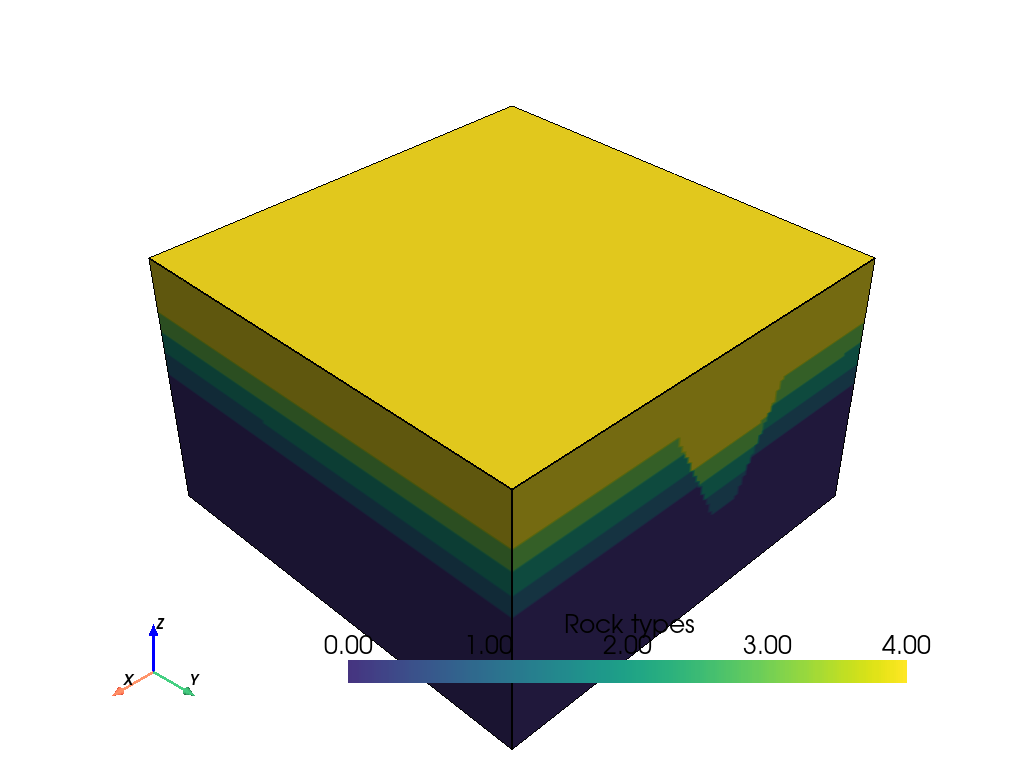

In [13]:
plot.stratigraphic(scalar_field_strats, notebook=True)

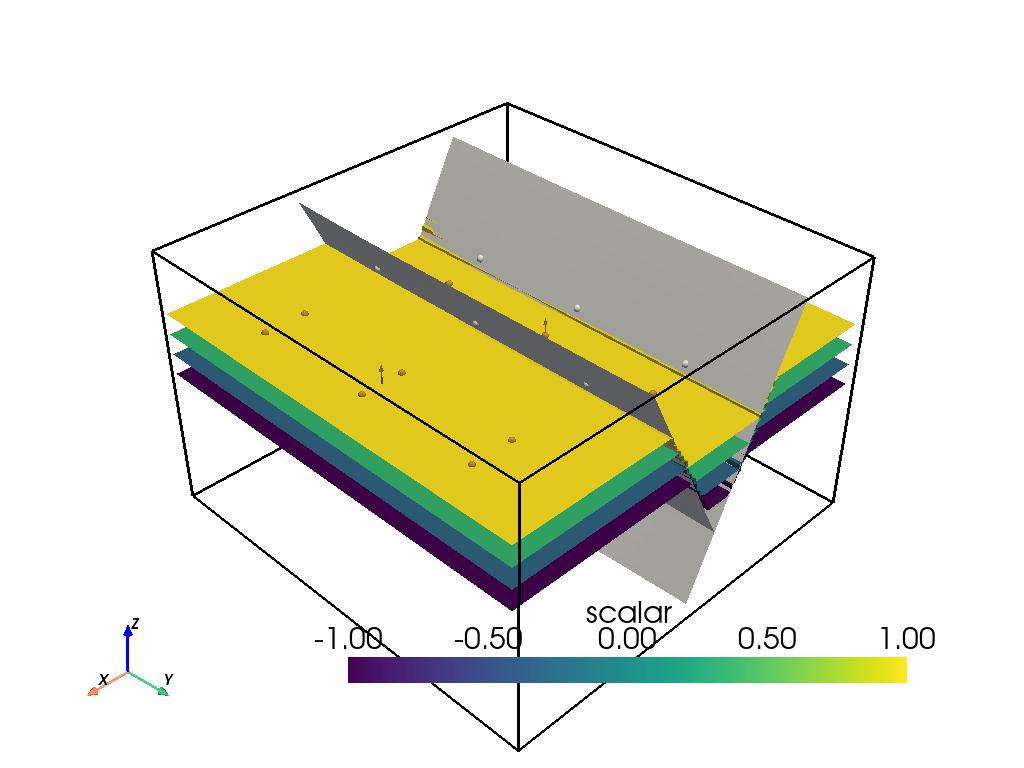

In [14]:
plot.final_structure(fautl_mesh_list = [finit_fault_1, fault_2],   # fault mesh list after editing
                        stratigraphic_mesh = stratigraphic_mesh,   # stratigraphic mesh
                        observation_data=True,                     # whether to plot the observation data, default is False
                        surface_points = surface_points,           # observation interface data
                        orientation_points = orientation_points,   # observation rientation data
                        extent=extent,                            # domain boundary   
                        notebook=True)                            # whether to plot the figure in notebook

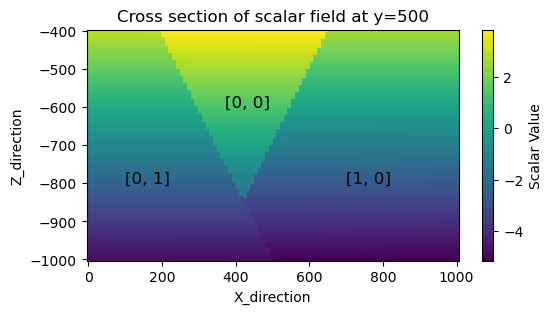

In [15]:
plot.slice(scalar_field_strats, extent, save_image=True)